### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

*Last update: 14 November 2023*

#### Libraries and helper functions
---

In [109]:
import torch
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302
from scipy.integrate import odeint

# from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

In [110]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    # If num_columns is 1, make ax iterable by wrapping it in a list
    if num_columns == 1:
        axs = [axs]

    # Now your existing loop should work without modification
    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [111]:
def plot_3d_trajectory(
    X, axis_labels=("Time", "Value", "Z Axis"), title="Trajectory", show=True
):
    """
    Plot a trajectory from a dataset, which can be 1D, 2D, or 3D.

    Parameters:
    - X: A 2D numpy array containing the trajectory data.
    - axis_labels: A tuple containing the labels for the axes. Default is ('Time', 'Value', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]
    dims = X.shape[1] if len(X.shape) > 1 else 1

    # Create a new figure for the plot
    fig = plt.figure()
    if dims >= 3:
        ax = fig.add_subplot(111, projection="3d")
        plot_dims = 3
    else:
        ax = fig.add_subplot(111)
        plot_dims = dims

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Extract coordinates from the data and plot accordingly
    if plot_dims == 1:
        x = np.arange(max_timesteps)
        y = X.flatten()
        z = np.zeros(max_timesteps)
        ax_labels = ("Time", axis_labels[0], "Fixed Z")
        # Plot the 1D trajectory with a color gradient
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    elif plot_dims == 2:
        x, y = X[:, 0], X[:, 1]
        z = np.zeros(max_timesteps)
        ax_labels = (axis_labels[0], axis_labels[1], "Fixed Z")
        # Plot the 2D trajectory
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    else:  # plot_dims == 3
        x, y, z = X[:, 0], X[:, 1], X[:, 2]
        ax_labels = axis_labels
        # Plot the 3D trajectory
        for i in range(1, max_timesteps):
            ax.plot(
                x[i - 1 : i + 1],
                y[i - 1 : i + 1],
                z[i - 1 : i + 1],
                color=colors[i],
                lw=0.5,
            )
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], z[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], z[-1], "ro", markersize=7)  # End with a red circle

    # Set labels for the axes
    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1])
    if plot_dims == 3:
        ax.set_zlabel(ax_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [112]:
def plot_autocorrelation_and_pacf(X, neurons):
    """
    Plot the autocorrelation and partial autocorrelation for each neuron's trajectory.

    Parameters:
    - X: A 2D numpy array of shape (max_timesteps, num_neurons) containing the neural trajectory data.
    - neurons: A list or array containing the neuron identifiers.

    Returns:
    - None: The function creates and displays a plot.
    """
    # Number of neurons
    num_neurons = X.shape[1]

    # Create a figure and an array of subplots with 2 columns
    fig, axes = plt.subplots(nrows=num_neurons, ncols=2, figsize=(10, 2 * num_neurons))

    # Set a suptitle for the entire figure
    fig.suptitle("Autocorrelation and Partial Autocorrelation for Neurons")

    # Iterate over the number of neurons to create individual plots
    for i in range(num_neurons):
        # Plot ACF on the left column (0th index)
        ax_left = axes[i, 0] if num_neurons > 1 else axes[0]
        plot_acf(X[:, i], ax=ax_left, use_vlines=False, marker="v", linestyle="--")
        ax_left.set_title(f"Neuron {neurons[i]} ACF")

        # Plot PACF on the right column (1st index)
        ax_right = axes[i, 1] if num_neurons > 1 else axes[1]
        plot_pacf(X[:, i], ax=ax_right, use_vlines=False, marker="*", linestyle="--")
        ax_right.set_title(f"Neuron {neurons[i]} PACF")
        ax_right.set_ylabel("")  # Clear the y-axis label to prevent clutter

        # Adjust y-axis limits so there is some white space around -1 and 1
        ax_left.set_ylim(-1.1, 1.1)
        ax_right.set_ylim(-1.1, 1.1)

        # Only the bottom plots need x-axis labels
        if i < num_neurons - 1:
            ax_left.set_xlabel("")
            ax_right.set_xlabel("")
        else:
            ax_left.set_xlabel("Lag")
            ax_right.set_xlabel("Lag")

    # Adjust the layout to not overlap plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plots
    plt.show()

In [113]:
def time_delay_embedding(x, delay, dimension):
    """
    Constructs a time-delay embedding matrix from time series data.

    :param x: Time series data as a 1D numpy array.
    :param delay: The delay \(\tau\) between time series elements in the embedding.
    :param dimension: The embedding dimension \(m\).
    :return: The time-delay embedded data as a 2D numpy array.
    """
    n = len(x)
    if n < (dimension - 1) * delay + 1:
        raise ValueError(
            "Time series data is too short for the given delay and dimension."
        )
    m = n - (dimension - 1) * delay
    embedded_data = np.empty((m, dimension))
    for i in range(m):
        for j in range(dimension):
            embedded_data[i, j] = x[i + j * delay]
    return embedded_data

In [114]:
def lorenz(X, t, sigma=10.0, beta=8.0 / 3, rho=28.0):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [115]:
def van_der_pol_oscillator(X, t, mu=1.0):
    """The Van der Pol oscillator equations."""
    x, y = X
    dx_dt = y
    dy_dt = mu * (1 - x**2) * y - x
    return [dx_dt, dy_dt]

In [116]:
class SinusoidsOscillator:
    def __init__(self, sum_freqs=0, random=True):
        self.eps = np.finfo(float).eps
        self.sum_freqs = sum_freqs
        self.random = random
        # create frequencies and phases
        if self.random:  # use random frequencies
            self.freqs = np.round(self.eps + np.random.random(self.sum_freqs) / 10, 4)
        else:  # use deterministic frequencies
            self.freqs = np.round(
                np.arange(1 / (2 * self.sum_freqs + self.eps), self.sum_freqs)
                / (10 * self.sum_freqs),
                4,
            )
        # always use random phases
        self.phases = np.random.random(self.sum_freqs) * 2 * np.pi

    def __call__(self, Y, t):
        y = Y
        dy_dt = -y + sum(
            np.cos(2 * np.pi * f * t + p) for f, p in zip(self.freqs, self.phases)
        )
        return dy_dt


# create an instance of this sinusoids dynamical system
sinusoids_oscillator = SinusoidsOscillator()

In [117]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

#### Sines dataset
---

In [118]:
def create_synthetic_dataset_sines(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    num_named_neurons=1,
    add_noise=False,
    noise_std=0.01,
    random_walk=False,
    sum_frequencies=1,
    random_freqs=False,
    delta_seconds=0.5,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_named_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Calculation of unknown neurons
    num_unknown_neurons = num_signals - num_named_neurons

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            neuron_index = i
            neuron_name = NEURONS_302[neuron_index]

            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                np.round(
                    eps + np.random.random(sum_frequencies) / 10, 4
                ).tolist()  # random frequencies
                if random_freqs
                else np.round(
                    np.arange(1 / (2 * sum_frequencies + eps), sum_frequencies)
                    / (10 * sum_frequencies),
                    4,
                ).tolist(),  # deterministic frequencies
            )

            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    for _ in range(sum_frequencies)
                ],
            )

            time_points = np.arange(max_timesteps)

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, neuron_index] += np.sin(
                    2 * np.pi * freq * time_points + phase
                )

            # Add noise
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(
                            loc=0, scale=noise_std, size=max_timesteps - 1
                        ).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [119]:
# Initialize parameters
max_timesteps = 3000
num_worms = 1
num_signals = 302
num_named_neurons = 3
add_noise = True
noise_std = 0.1
random_walk = True
sum_frequencies = 0
random_freqs = True
delta_seconds = 0.5
smooth_method = None  # "GA"
transform = StandardScaler()
dataset_name = "Sines0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    :num_named_neurons
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

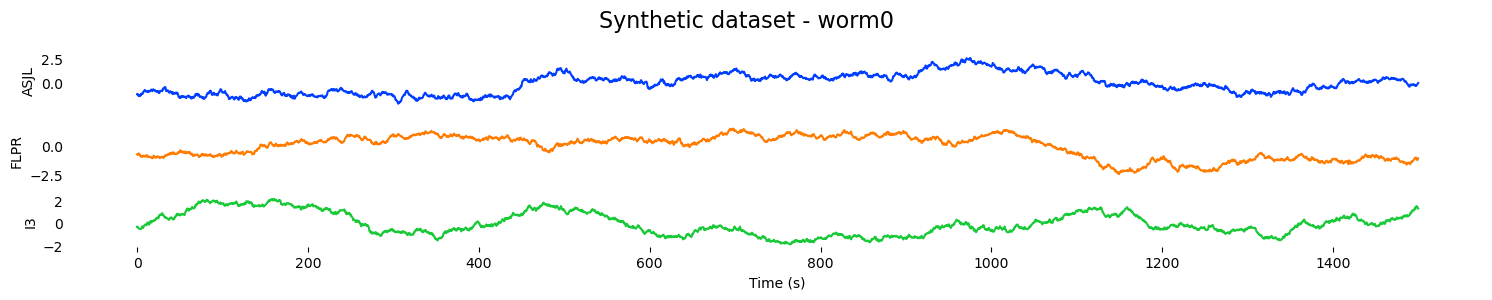

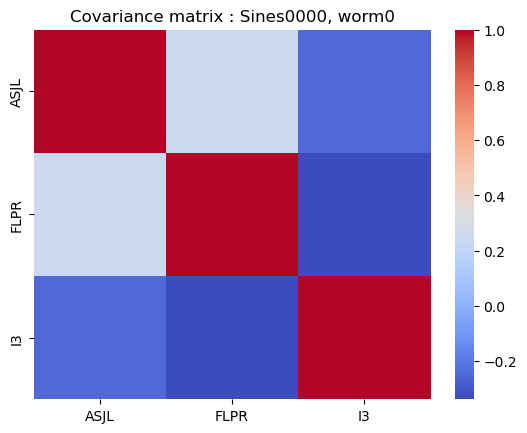

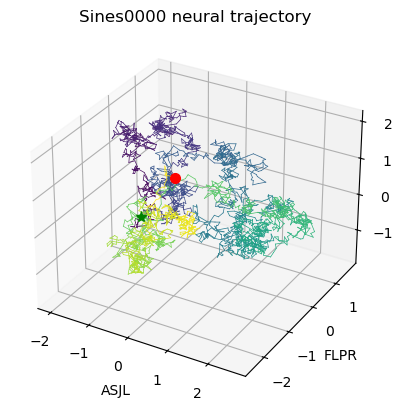

In [120]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory"
)

#### Autocorrelation
---
Autocorrelation and partial autocorrelation are concepts used in time series analysis to examine the relationship of a variable with itself at different lags.

**Autocorrelation Function (ACF):**
- This is a correlation of a signal with a delayed copy of itself as a function of delay.
- The autocorrelation plot (or ACF plot) displays the correlation between the time series and its lagged values.
- The y-axis shows the autocorrelation coefficient, which ranges from -1 to 1. A value of 1 indicates perfect positive correlation, while -1 indicates perfect negative correlation.
- The x-axis represents the lag at which the autocorrelation is computed. For example, at lag 1, you're comparing the series with itself one time step back.
- The ACF considers the combined effect of all previous time points up to the lagged time point being calculated. It doesn't isolate the correlation at each lag.

**Partial Autocorrelation Function (PACF):**
- This measures the correlation between the time series and its lagged version after accounting for the variations already explained by the intervening comparisons. In other words, it controls for the previous lags.
- The PACF plot shows the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags.
- It isolates the additional correlation at a particular lag that is not explained by previous lags. This is useful to identify the actual lagged relationship, without the confounding effects of the correlations at shorter lags.

In summary, while the ACF shows the cumulative effect of past data points on the current value, the PACF removes this cumulative effect and tries to show the unique contribution of each past data point.

In practical applications like ARIMA (AutoRegressive Integrated Moving Average) modeling, the ACF and PACF are used to determine the AR (autoregressive) and MA (moving average) terms:

* The PACF helps to identify the order of the AR part (p) by finding the lag after which the PACF cuts off (drops to zero or below the significance level).
* The ACF is used to identify the order of the MA part (q) by finding the lag after which the ACF cuts off.





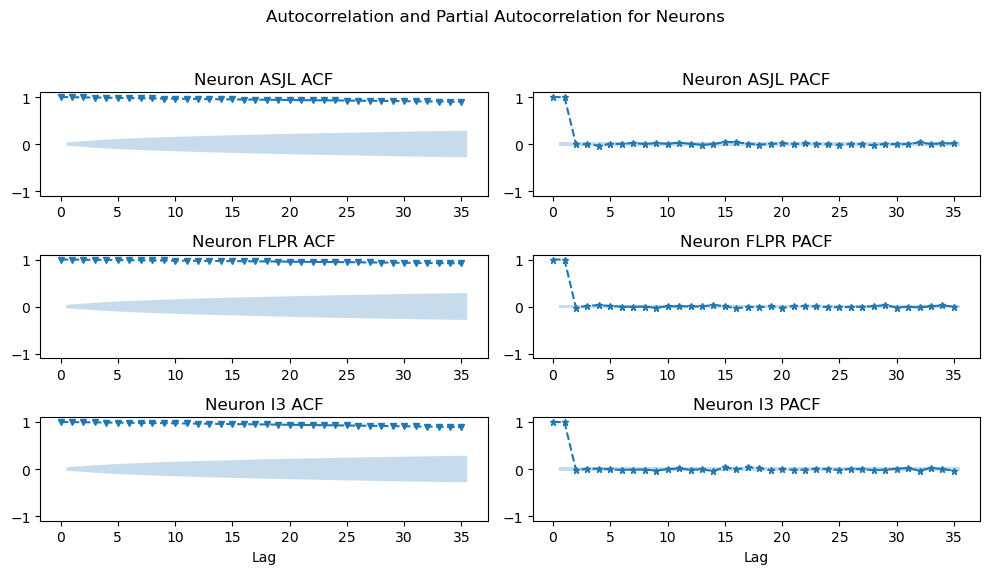

In [121]:
# Plotting autocorrelation and partial autocorrelation

# X is our data matrix (time, untis) and neurons is a list of names for each unit
plot_autocorrelation_and_pacf(X, neurons)

#### Lorenz dataset
---

In [122]:
def create_synthetic_dataset_lorenz(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    num_lorenz_systems=1,
    add_noise=False,
    noise_std=0.01,
    random_walk=False,
    fine_integration_step=0.1,
    delta_seconds=0.5,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Lorenz0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_lorenz_systems: The number of Lorenz systems to use for creating the synthetic data.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Calculate number of named and unknown neurons
    num_named_neurons = num_lorenz_systems * 3
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(
        0, max_timesteps * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent Lorenz systems
        for system_idx in range(num_lorenz_systems):
            # Define a new set of initial conditions for each Lorenz system
            initial_conditions = np.random.randn(
                3
            )  # or other method to generate initial conditions

            # Integrate the Lorenz system with different initial conditions
            fine_trajectories = odeint(lorenz, initial_conditions, fine_time_points)

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(3):
                neuron_index = named_neuron_indices[system_idx * 3 + i]
                calcium_data[:, neuron_index] = sampled_trajectories[:, i]

                # Add noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)
                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [123]:
# Initialize parameters
max_timesteps = 5000
num_worms = 1
num_signals = 302
num_lorenz_systems = 1
add_noise = True
noise_std = 0.1
random_walk = True
fine_integration_step = 0.05
delta_seconds = 0.05
smooth_method = None  # "GA"
transform = StandardScaler()
dataset_name = "Lorenz0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_lorenz(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_lorenz_systems=num_lorenz_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_lorenz_systems * 3
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

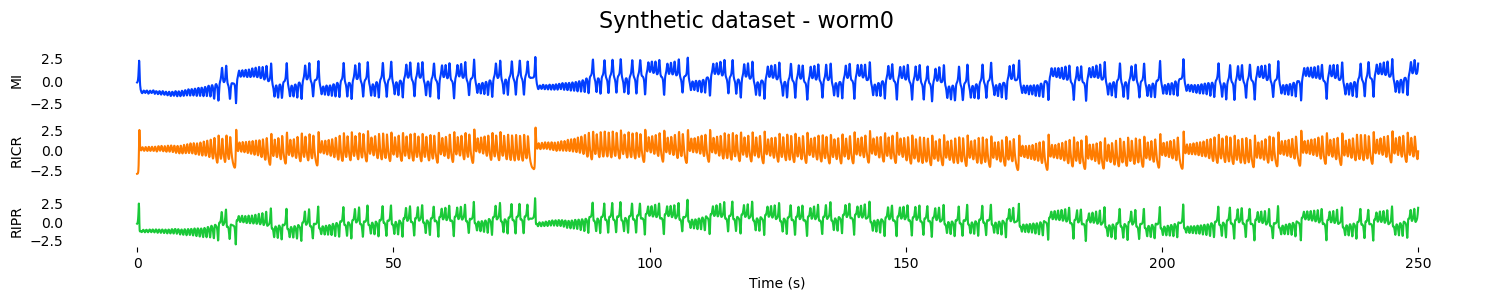

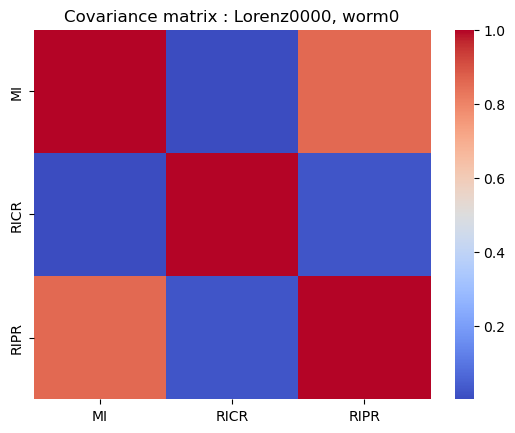

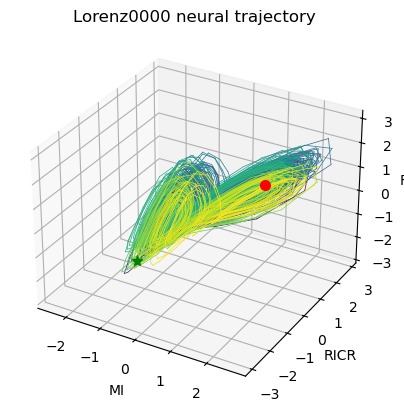

In [124]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory"
)

#### Time Delay Embedding
---
Time delay embedding is a technique used in the analysis of dynamical systems, particularly in the context of reconstructing the phase space of a system from a series of observations over time. This technique is based on Takens' Embedding Theorem, which states that the dynamics of a system can be reconstructed from the time series of a single observable of the system, under certain conditions.

Here are some key points about time delay embedding:

- **Time Delay, τ (tau):** This is the time interval between successive observations in the reconstructed phase space. Choosing an appropriate τ is crucial; too short a delay may lead to redundant information, while too long a delay may lose the dynamics of interest.

- **Embedding Dimension, m:** This represents the number of delayed observations used to reconstruct the phase space. It should be high enough to unfold the dynamics, but not too high to avoid overcomplicating the model.

- **Phase Space Reconstruction:** By plotting the time-delayed copies of the time series against each other, one can reconstruct the phase space, which can reveal underlying dynamical properties like attractors or limit cycles.

- **Mutual Information:** To empirically choose the right τ, one common method is to calculate the mutual information between the time series and its delayed version, and select τ at the first minimum of the mutual information function.

- **False Nearest Neighbors (FNN):** The method of False Nearest Neighbors can help determine a suitable embedding dimension m by identifying when points that appear to be neighbors in lower-dimensional space are no longer neighbors in higher dimensions.


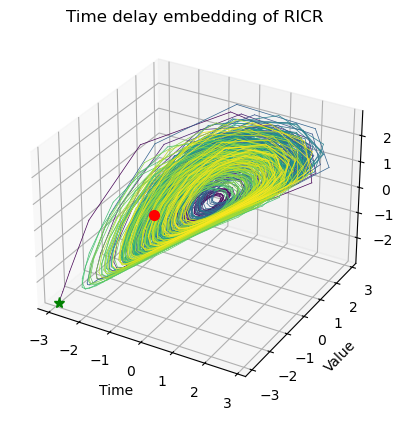

In [125]:
# Example usage:
# Let's assume you have a time series data stored in a variable called `time_series_data`.
idx = 1
time_series_data = X[:, idx]
# You would first determine `tau` and `m` based on your data.

tau = 1  # replace with the delay you've computed or chosen
m = 3  # replace with the embedding dimension you've computed or chosen

# You can then compute the time-delay embedding of your data as follows:
embedded_data = time_delay_embedding(time_series_data, tau, m)
plot_3d_trajectory(embedded_data, title=f"Time delay embedding of {neurons[idx]}")

### Dynamics dataset
___

We attempt to generalize the above approach to generating synthetic data from dynamical systems more generally.

In [126]:
def create_synthetic_dataset_dynamics(
    dynamics_func: callable,
    state_dim: int,
    func_args: tuple = (),
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_dynamic_systems: int = 1,
    add_noise: bool = False,
    random_walk: bool = False,
    noise_std: float = 0.01,
    fine_integration_step: float = 0.1,
    delta_seconds: float = 0.5,
    smooth_method: str = "GA",
    transform: callable = StandardScaler(),
    dataset_name="Dynamics0000",
):
    """
    Create a synthetic worm dataset using a user-defined dynamical system.

    Parameters:
    :param dynamics_func: The function defining the dynamics, should take arguments (y, t, *args).
    :param state_dim: The dimension of the state vector y to the dynamics function.
    :param func_kwargs: Any extra arguments to pass to the dynamics function.
    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_dynamic_systems: The number of independent dynamical systems to use for creating the synthetic data.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: Whether to add Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.

    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Calculate number of named and unknown neurons
    num_named_neurons = num_dynamic_systems * state_dim
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(
        0, max_timesteps * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent systems; same dynamics but different initial conditions
        for system_idx in range(num_dynamic_systems):
            # Define a new set of initial conditions for each system
            initial_conditions = np.random.randn(
                state_dim
            )  # or other method to generate initial conditions

            # Integrate the dynamical system
            fine_trajectories = odeint(
                dynamics_func,
                initial_conditions,
                fine_time_points,
                args=func_args,
            )

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(state_dim):
                neuron_index = named_neuron_indices[system_idx * state_dim + i]
                calcium_data[:, neuron_index] = sampled_trajectories[:, i]

                # Add noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)

                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [127]:
# Define the parameters
# dynamics_func = sinusoids_oscillator
dynamics_func = van_der_pol_oscillator
state_dim = 2
func_args = ()
max_timesteps = 5000
num_worms = 1
num_signals = 302
num_dynamic_systems = 1
add_noise = True
noise_std = 0.1
random_walk = True
fine_integration_step = 0.05
delta_seconds = 0.05
smooth_method = None  # "GA"
transform = StandardScaler()
dataset_name = "VanDerPol0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)


# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

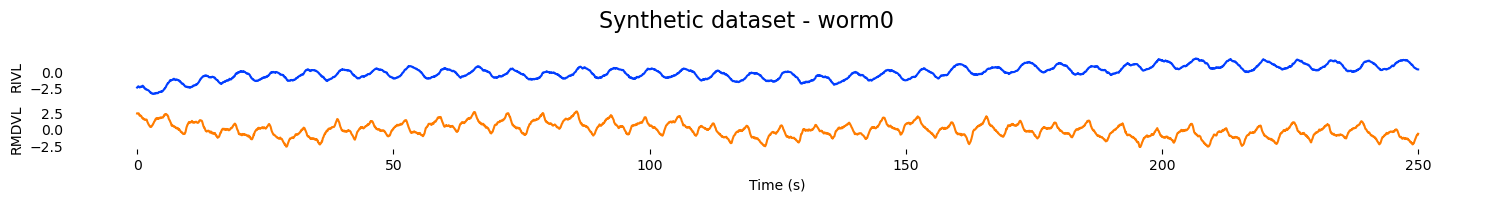

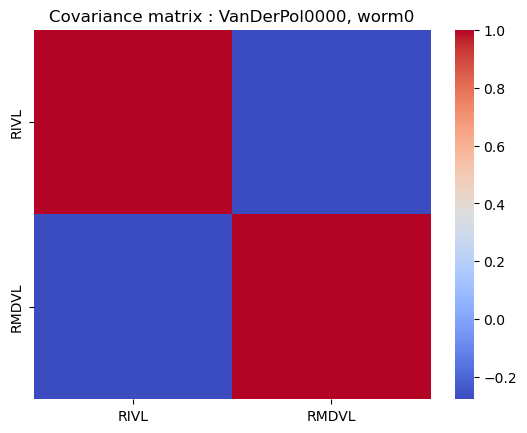

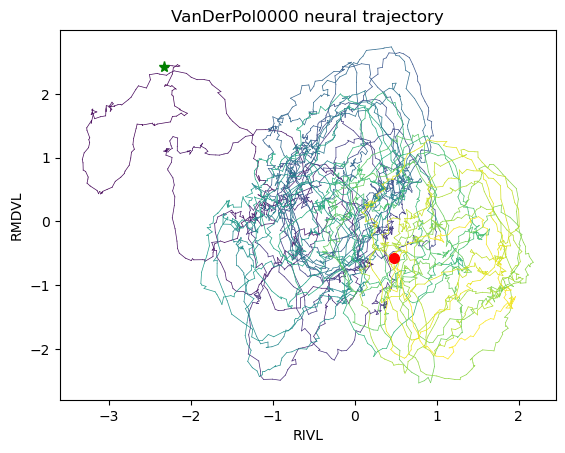

In [128]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory"
)